In [1]:
from pyteomics import mgf
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
import seaborn as sns
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/all_sampleinformation.tsv',sep='\t')
df = df[~df['filename'].str.contains('qc',case=False)]
df = df[~df['filename'].str.contains('blank',case=False)]
df = df[df['SampleType']=='plant']
df.shape

/tmp/ipykernel_53299/2521677813.py:1: DtypeWarning: Columns (7,11,21,22,28,30,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/all_sampleinformation.tsv',sep='\t')


(8638, 37)

In [6]:
df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')
df = df[df['SampleType']=='plant']

df = df[~df['buddy'].str.contains('qc',case=False)]
df = df[~df['buddy'].str.contains('blank',case=False)]
out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
temp_files = df['h5'].tolist()
files = []
for f in temp_files:
    base_dir = os.path.dirname(f)
    base_name = os.path.basename(f)
    new_dir = os.path.join(out_dir,base_dir)
    new_name = os.path.join(new_dir,base_name)
    files.append(new_name)
    if not os.path.isfile(new_name):
        print('File Not Found!')
        print(new_name)
        print(f)
files = pd.DataFrame(files,columns=['filename'])
files.shape

(595, 1)

In [5]:
df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')

df = df[~df['buddy'].str.contains('qc',case=False)]
df = df[~df['buddy'].str.contains('blank',case=False)]
# df['keywords'] = df['keywords'].apply(lambda x: x.split('###') if type(x)==str else [])
# df['keyword_DOM'] = df['keywords'].apply(lambda x: True if (('dom' in x) | ('organic matter' in x) | ('soil' in x)) else False)
idx1 = (df['in_massive_dom_list'])# | df['keyword_DOM']
# idx2 = (df['SampleType']=='plant')

# idx2 = df['data_dir']=='/global/cfs/cdirs/metatlas/projects/massive_data_for_scn'
idx3 = df['buddy'].str.contains('rawdata_for_scn')
# df = df[(idx3)]# | (idx1)] #  | (idx2)
df = df[(idx3) | (idx1)] #  | (idx2)
# df = df[df['SampleType']=='plant']
file_metadata = df.copy()


out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
temp_files = df['h5'].tolist()
files = []
for f in temp_files:
    base_dir = os.path.dirname(f)
    base_name = os.path.basename(f)
    new_dir = os.path.join(out_dir,base_dir)
    new_name = os.path.join(new_dir,base_name)
    files.append(new_name)
    if not os.path.isfile(new_name):
        print('File Not Found!')
        print(new_name)
        print(f)
files = pd.DataFrame(files,columns=['filename'])
print(files.shape)
my_files = files.sample(20)['filename'].tolist()


(2258, 1)


In [7]:
edges = np.logspace(np.log10(150),np.log10(700),int(1e5))
# edges[2000000:2000010]

In [ ]:
from concurrent.futures import ThreadPoolExecutor
my_files = files['filename'].tolist()

import concurrent.futures

def process_file(f):
    d = ft.df_container_from_metatlas_file(f,desired_key='ms1_neg')
    d = d[d['rt']>1]
    d = d[d['mz']>edges[0]]
    d = d[d['mz']<edges[-1]]
    y,bins = np.histogram(d['mz'],bins=edges,weights=d['i'])
    idx = y>0
    y = y[idx]
    mean_mz = (bins[:-1][idx] + bins[1:][idx])/2
    return (y[idx],mean_mz)

# Create a ThreadPoolExecutor with the desired number of workers
with ThreadPoolExecutor(max_workers=20) as executor:
    # Submit each file to the executor for processing
    futures = [executor.submit(process_file, filename) for filename in my_files]

    # Wait for all futures to complete
    concurrent.futures.wait(futures)


# Get the results from each future
results = [future.result() for future in futures]

In [79]:

y = [1.1,10.1,11.1]
x = [0.95,0.9,3.1]
edges = [0,1,2,3]
y = np.asarray(y)
x = np.asarray(x)
edges = np.asarray(edges)
bin_indices = np.digitize(x,edges)
# histogram = coo_matrix((y, (bin_indices, np.zeros_like(bin_indices))), shape=(len(edges), 1)).tocsc()
# print(bin_indices,histogram)
col_indices = np.zeros_like(bin_indices)
m = (y, (bin_indices, col_indices))
c = coo_matrix(m, shape=(len(edges)+1, 1))
s = c.tocsc()
# y,bin_indices,col_indices
s.toarray()


array([[ 0. ],
       [11.2],
       [ 0. ],
       [ 0. ],
       [11.1]])

In [8]:
from scipy.sparse import coo_matrix
from concurrent.futures import ThreadPoolExecutor
my_files = files['filename'].tolist()

import concurrent.futures

# Initialize an empty histogram
histogram = coo_matrix((len(edges), 1), dtype=np.float64).tocsc()

# Process each file in the list
def process_file(f):

    d = ft.df_container_from_metatlas_file(f, desired_key='ms1_neg')
    d = d[d['rt']>1]
    d = d[d['mz']>edges[0]]
    d = d[d['mz']<edges[-1]]

    # Calculate the bin indices for each mz value
    bin_indices = np.digitize(d['mz'], bins=edges)

    # Create a sparse histogram for the current file and sum it into the total histogram
    histogram = coo_matrix((d['i'], (bin_indices, np.zeros_like(bin_indices))), shape=(len(edges), 1)).tocsc()
    return histogram

# Create a ThreadPoolExecutor with the desired number of workers
with ThreadPoolExecutor(max_workers=20) as executor:
    # Submit each file to the executor for processing
    futures = [executor.submit(process_file, filename) for filename in my_files]

    # Wait for all futures to complete
    concurrent.futures.wait(futures)

results = [future.result() for future in futures]
# Initialize an empty histogram



In [9]:
histogram = coo_matrix((len(edges), 1), dtype=np.float64).tocsc()
for r in results:
    r = r / r.max()
    histogram += r

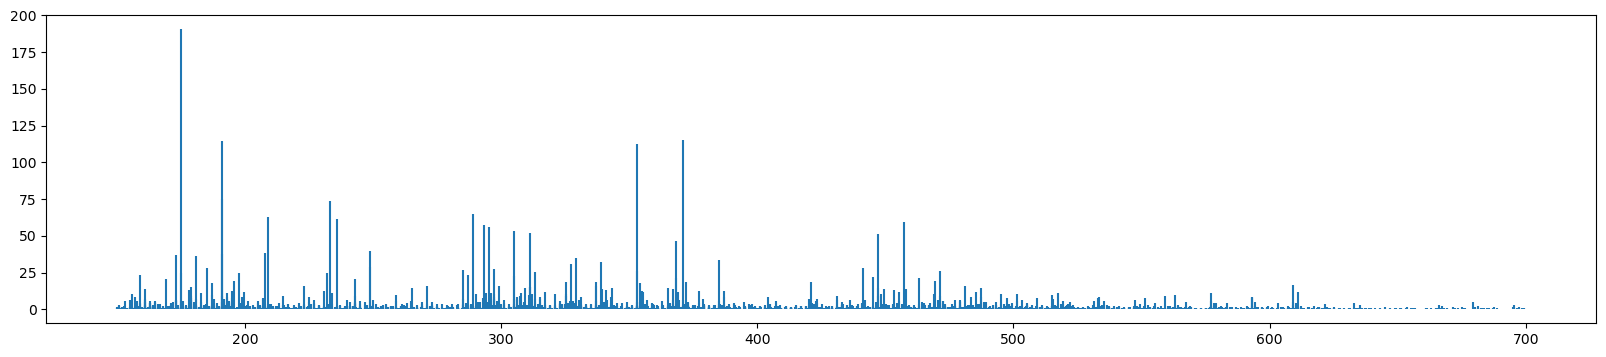

In [12]:
fig,ax = plt.subplots(figsize=(20,4))
ax.vlines(edges,0*edges,histogram.toarray().flatten())
# ax.xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=False))
ax.ticklabel_format(useOffset=False)
# ax.axvline(t,color='r')
plt.show()

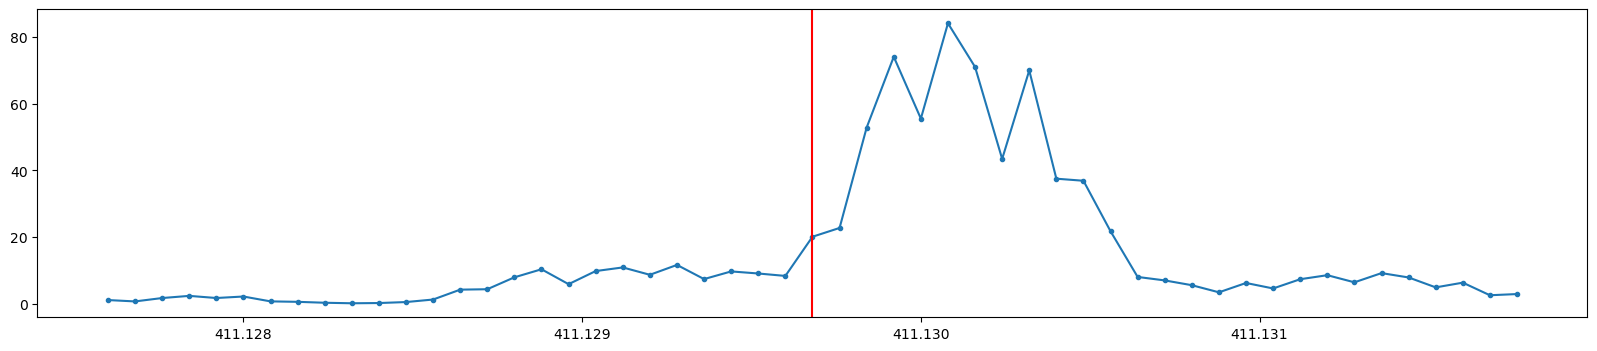

In [43]:
t = 311.11362
# t = 309.09797
# t = 297.09797
# t = 323.11362
# t = 325.12927
t = 411.12968
idx = abs(edges-t)<0.0021
fig,ax = plt.subplots(figsize=(20,4))
ax.plot(edges[idx],histogram[idx].toarray().flatten(),'.-')
# ax.xaxis.set_major_formatter(plt.ScalarFormatter(useMathText=False))
ax.ticklabel_format(useOffset=False)
ax.axvline(t,color='r')
plt.show()

In [ ]:
y = np.asarray(results)
y = np.median(y,axis=0)
# y = y.sum(axis=0)a
# y = y / len(my_files)


In [ ]:

fig,ax = plt.subplots(figsize=(15,4))
y = y + 1
ax.vlines(edges[:-1],1 + 0*y,y)
ax.set_ylabel('Median Intensity Across %d Files'%len(my_files))
ax.set_xlabel('m/z')
# ax.set_xlim(310.9,311.5)
ax.set_yscale('log')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the pairwise distances between rows
# cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
distances = np.asarray(results)

# Perform hierarchical clustering
Z = linkage(distances, method='average', metric='euclidean')

# Get the order of the rows based on the clustering
order = dendrogram(Z, no_plot=True)['leaves']

# Reorder the rows of cluster_df
# cluster_df = cluster_df.iloc[order]
ordered_results = [results[i] for i in order]
# Show the reordered cluster_df
# cluster_df[cols]


In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
y = np.asarray(ordered_results)
y = y + 1
y = np.log10(y)
sns.heatmap(y,ax=ax)
# ax.set_xticks(np.arange(0,len(edges),10000)
# ax.set_xticklabels(edges[:-1])

plt.show()

In [ ]:
# out.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/all_berkeley_lab_data.pkl')
# out.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/century_experiment_data.pkl')
# out.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/wavestab3_data.pkl')
# out.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/plantmasst_data.pkl')
out.to_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/allCarbonData.pkl')

In [ ]:
# out = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/all_berkeley_lab_data.pkl')
# out = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/wavestab3_data.pkl')
# out = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/century_experiment_data.pkl')
out = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/allCarbonData.pkl')
out_plant = pd.read_pickle('/global/cfs/cdirs/metatlas/projects/carbon_network/temp_data/plantmasst_data.pkl')


In [ ]:
def make_spectrum(out):
    # y_col = 'peak_height'
    y_col = 'peak_area'
    cols = ['mz_centroid',y_col]
    # & (out['num_datapoints']>1) & (out['peak_height']<1e80) & (out['peak_height']>1)
    y = out[(out['mz_centroid']>150)].groupby('node_id')[cols].median()
    # y = y[y['peak_area']<1e9]
    y.reset_index(inplace=True,drop=True)
    fig, ax = plt.subplots(figsize=(15,4))
    ax.vlines(y['mz_centroid'],0*y[y_col],y[y_col])
    # ax.set_xlim(300.0,320)
    # ax.set_yscale('log')

make_spectrum(out)
make_spectrum(out_plant)